In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
#print('TF version: ', tf.__version__)
#print('Eager execution enabled: ', tf.executing_eagerly()) # True

In [4]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()
test_labels = y_test.copy()
train_labels = y_train.copy()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [14]:
inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(.3)(x)
x = Conv2D(32, 2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(.3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.5)(x)
logits = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=logits)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# train model
model.fit(X_train, y_train,epochs=6,batch_size=256,verbose=1,validation_data=(X_test, y_test))

Epoch 1/6
235/235 [==============================] - 25s 105ms/step - loss: 0.4928 - accuracy: 0.8450 - val_loss: 0.1140 - val_accuracy: 0.9664
Epoch 2/6
235/235 [==============================] - 27s 114ms/step - loss: 0.1617 - accuracy: 0.9497 - val_loss: 0.0700 - val_accuracy: 0.9789
Epoch 3/6
235/235 [==============================] - 27s 115ms/step - loss: 0.1174 - accuracy: 0.9647 - val_loss: 0.0528 - val_accuracy: 0.9835
Epoch 4/6
235/235 [==============================] - 27s 117ms/step - loss: 0.0977 - accuracy: 0.9696 - val_loss: 0.0455 - val_accuracy: 0.9848
Epoch 5/6
235/235 [==============================] - 30s 127ms/step - loss: 0.0858 - accuracy: 0.9729 - val_loss: 0.0416 - val_accuracy: 0.9869
Epoch 6/6
235/235 [==============================] - 37s 157ms/step - loss: 0.0770 - accuracy: 0.9754 - val_loss: 0.0378 - val_accuracy: 0.9869


In [15]:
ig = IntegratedGradients(model,)
X_test_sample = X_test[:10]
predictions = model.predict(X_test_sample).argmax(axis=1)
explanation = ig.explain(X_test_sample,baselines=None,target=predictions)

1/1 [==============================] - 0s 73ms/step


In [16]:
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'target_fn': None,
  'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 0},
 'version': '0.9.0'}

In [9]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

In [20]:
attrs = explanation.attributions[0]
print(attrs.shape)
print(attrs.min(), attrs.max())

(10, 28, 28, 1)
-0.10980081270870781 0.12210678440522395


In [21]:
base=explanation.baselines[0]
print(base.shape)
print(np.unique(base))

(28, 28, 1)
[0.]


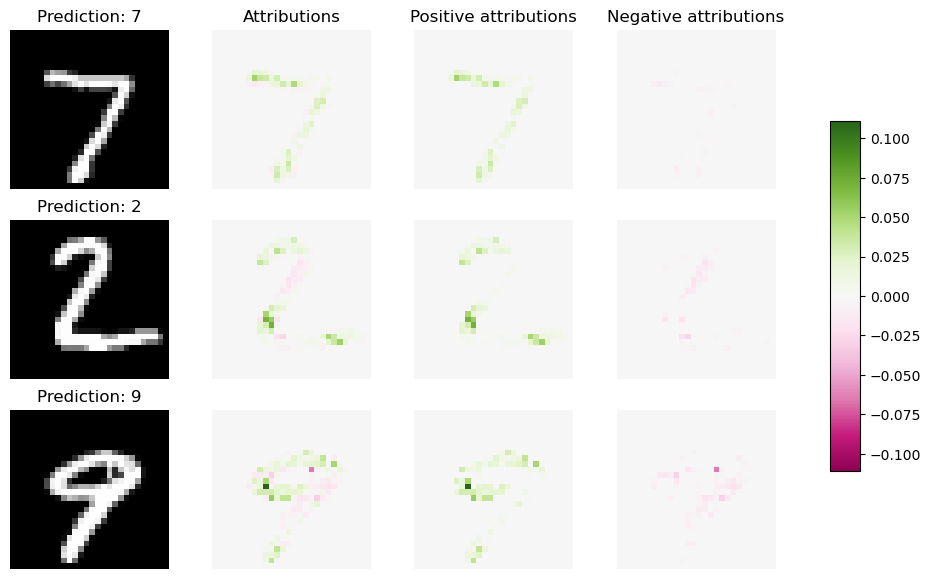

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
image_ids = [0, 1, 9]
cmap_bound = np.abs(attrs[[0, 1, 9]]).max()
for row, image_id in enumerate(image_ids):
    # original images
    ax[row, 0].imshow(X_test[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions[image_id]}')
    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    # positive attributions
    attr_pos = attr.clip(0, 0.2)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound,cmap='PiYG')
    # negative attributions
    attr_neg = attr.clip(-0.2, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound,cmap='PiYG')
ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');
for ax in fig.axes:
    ax.axis('off')
fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]));